In [58]:
import os
import glob
import numpy as np
import pandas as pd
import sys
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sns
from scipy import stats

In [59]:
# define the paths to results

data_path  = 'Results/*'

# get results' file paths

file_path_list  = glob.glob(data_path)

# split file names

file_names = [file_path.split('/')[1] for file_path in file_path_list]

file_names

['results__batch_size__200__encoding_dim__8__lambda_disco__300__act_1__tanh__act_2__relu__act_3__tanh__it__20__02-Sep-2021-01.09.57__.csv',
 'Error__batch_size__200__encoding_dim__14__lambda_disco__300__act_1__sigmoid__act_2__sigmoid__act_3__relu__it__20__02-Sep-2021-05.38.33.txt',
 'results__batch_size__200__encoding_dim__8__lambda_disco__600__act_1__sigmoid__act_2__relu__act_3__tanh__it__20__01-Sep-2021-23.25.29__.csv',
 'Error__batch_size__500__encoding_dim__21__lambda_disco__0__act_1__tanh__act_2__sigmoid__act_3__tanh__it__20__31-Aug-2021-07.57.17.txt',
 'results__batch_size__350__encoding_dim__8__lambda_disco__300__act_1__sigmoid__act_2__relu__act_3__sigmoid__it__20__01-Sep-2021-02.03.17__.csv',
 'results__batch_size__500__encoding_dim__8__lambda_disco__600__act_1__relu__act_2__relu__act_3__tanh__it__20__30-Aug-2021-13.53.23__.csv',
 'results__batch_size__200__encoding_dim__14__lambda_disco__600__act_1__relu__act_2__relu__act_3__tanh__it__20__02-Sep-2021-03.23.23__.csv',
 'results

In [60]:

# clear models with error

valid_models_path = [ data_path.split('*')[0] + file_name for file_name in file_names 
                                            if file_name.split('__')[0] != 'Error']

print('Number of models studied: {}'.format(len(file_names)))
print('Number of valid models: {}'.format(len(valid_models_path)))

# creating dictionary for model exploration

results_ditc = {}

n_elements = len(valid_models_path)

for i,results in enumerate(valid_models_path):


    #Loading results

    name = results.split('/')[1]

    results_ditc[name] = {}

    results_ditc[name]['data'] = pd.read_csv(results)

    #Updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()
    


Number of models studied: 1198
Number of valid models: 547
[----------------------------------------------------------------------------------------------------] 100.00% - 547 of 547

In [61]:
results_ditc

{'results__batch_size__200__encoding_dim__8__lambda_disco__300__act_1__tanh__act_2__relu__act_3__tanh__it__20__02-Sep-2021-01.09.57__.csv': {'data':        Unnamed: 0       px1       py1       pz1        E1      eta1      phi1  \
  0               0 -0.107807  0.277014 -0.126378  0.148448 -0.350496  0.639023   
  1               1 -0.189030  0.208444  0.062762  0.100615  0.203787  0.763377   
  2               2 -0.063092 -0.246698  0.071365  0.096747  0.261574 -0.594749   
  3               3 -0.000343  0.249139  0.097950  0.116605  0.338721  0.500531   
  4               4 -0.000919  0.192576 -0.073447  0.088284 -0.331676  0.501827   
  ...           ...       ...       ...       ...       ...       ...       ...   
  29995       29995  0.035598 -0.276192  0.243020  0.252850  0.539275 -0.451181   
  29996       29996 -0.222854 -0.027050  0.028133  0.073977  0.111388 -0.967907   
  29997       29997 -0.144152 -0.153879  0.015433  0.061549  0.072037 -0.768518   
  29998       29998  0.

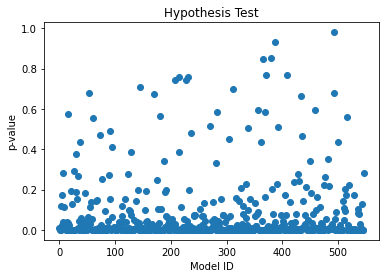

In [62]:
error_ks = []
Class = []

for model in results_ditc.keys():

    df = results_ditc[model]['data']

    y = df[::]["class"].values

    error = df[::]["reconstruction_error"].values

    signal_error = error[y==1]

    background_error = error[y==0]

    results_ditc[model]['error_ks'] = stats.ks_2samp(signal_error, 
                                                             background_error).pvalue

    error_ks.append(stats.ks_2samp(signal_error, 
                                           background_error).pvalue)




fig, ax = plt.subplots()

ax.scatter([x for x in range(len(error_ks))], error_ks)
plt.title("Hypothesis Test")
plt.ylabel("p-value")
plt.xlabel("Model ID")

fig.savefig('Figures/reconstruction-error__.png', 
            bbox_inches='tight'
        )

In [63]:

sorted_index = np.argsort(error_ks)

sort_error_difference = [error_ks[i] for i in sorted_index]

model_names = [name for name in results_ditc.keys()]

sort_model_names = [model_names[i] for i in sorted_index]

small_model_names = sort_model_names[:10]

error_df = pd.DataFrame(np.transpose(sort_error_difference[:10]),index=small_model_names)

display(error_df)


,0
results__batch_size__200__encoding_dim__8__lambda_disco__600__act_1__tanh__act_2__sigmoid__act_3__sigmoid__it__20__02-Sep-2021-00.01.41__.csv,4.543892e-19
results__batch_size__500__encoding_dim__8__lambda_disco__600__act_1__tanh__act_2__sigmoid__act_3__sigmoid__it__20__30-Aug-2021-16.22.04__.csv,8.082760e-18
results__batch_size__200__encoding_dim__21__lambda_disco__600__act_1__sigmoid__act_2__relu__act_3__relu__it__20__02-Sep-2021-09.09.20__.csv,9.131233e-15
results__batch_size__500__encoding_dim__14__lambda_disco__600__act_1__sigmoid__act_2__relu__act_3__relu__it__20__30-Aug-2021-21.18.33__.csv,1.620851e-14
results__batch_size__500__encoding_dim__14__lambda_disco__300__act_1__relu__act_2__sigmoid__act_3__relu__it__20__30-Aug-2021-22.45.15__.csv,8.658137e-10
results__batch_size__200__encoding_dim__14__lambda_disco__600__act_1__relu__act_2__sigmoid__act_3__tanh__it__20__02-Sep-2021-03.30.40__.csv,9.364414e-09
results__batch_size__500__encoding_dim__14__lambda_disco__600__act_1__relu__act_2__sigmoid__act_3__tanh__it__20__30-Aug-2021-21.08.14__.csv,9.432673e-09
results__batch_size__500__encoding_dim__8__lambda_disco__0__act_1__relu__act_2__sigmoid__act_3__sigmoid__it__20__30-Aug-2021-18.48.15__.csv,1.739849e-08
results__batch_size__500__encoding_dim__21__lambda_disco__300__act_1__relu__act_2__sigmoid__act_3__sigmoid__it__20__31-Aug-2021-04.25.50__.csv,1.978105e-08
results__batch_size__200__encoding_dim__8__lambda_disco__0__act_1__tanh__act_2__sigmoid__act_3__sigmoid__it__20__02-Sep-2021-03.06.06__.csv,2.345630e-08


In [64]:
best_model_df = results_ditc[sort_model_names[0]]['data']

error_class = pd.DataFrame({'Reconstruction_error': best_model_df[::]['reconstruction_error'],
                        'True_class': best_model_df[::]['class']})

error_class.head()                        

,Reconstruction_error,True_class
0,0.146221,0.0
1,0.133841,0.0
2,0.126138,0.0
3,0.135178,0.0
4,0.131438,0.0


In [65]:
normal_name = 'results__batch_size__200__encoding_dim__8__lambda_disco__0__act_1__tanh__act_2__sigmoid__act_3__sigmoid__it__20__02-Sep-2021-03.06.06__.csv'

normal_version = results_ditc[normal_name]['data']

n_error_class = pd.DataFrame({'Reconstruction_error': normal_version[::]['reconstruction_error'],
                        'True_class': normal_version[::]['class']})

n_error_class.head()                        


,Reconstruction_error,True_class
0,0.163049,0.0
1,0.165850,0.0
2,0.169137,0.0
3,0.144644,0.0
4,0.150008,0.0


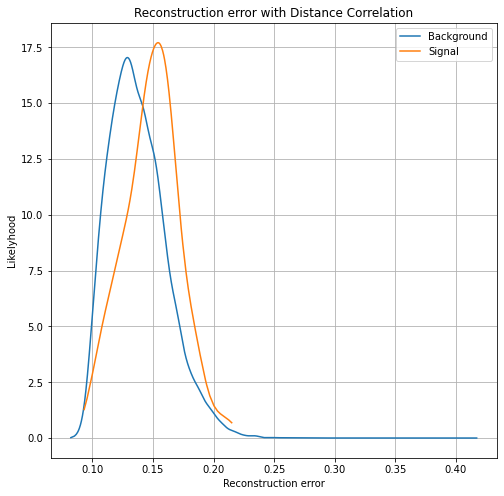

In [79]:

threshold_fixed = 0.12
groups = error_class.groupby('True_class')

print(groups)

n_threshold_fixed = 0.12
n_groups = n_error_class.groupby('True_class')

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

threshold_fixed = 0.155


for name, group in groups:
    

    kernel = stats.gaussian_kde(group.Reconstruction_error)

    if name == 0:
        labels = "Background"
    
    elif name == 1:
        labels = "Signal"

    else:
        labels = "Training set"


    ax.plot(np.sort(group.Reconstruction_error), kernel(np.sort(group.Reconstruction_error)), 
            ms=3.5, linestyle='-',
            label= labels)

ax.legend()
ax.set_title("Reconstruction error with Distance Correlation")
ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Likelyhood")
ax.grid()
"""
for name, group in n_groups:
    

    kernel_n = stats.gaussian_kde(group.Reconstruction_error)

    if name == 0:
        labels = "Background"
    
    elif name == 1:
        labels = "Signal"

    else:
        labels = "Training set"

    ax[1].plot(np.sort(group.Reconstruction_error), kernel_n(np.sort(group.Reconstruction_error)), 
            ms=3.5, linestyle='-',
            label= labels)

ax[1].legend()
ax[1].set_title("Reconstruction error without Distance Correlation")
ax[1].set_xlabel("Reconstruction error")
ax[1].set_ylabel("Likelyhood")
ax[1].grid()
"""
plt.show()


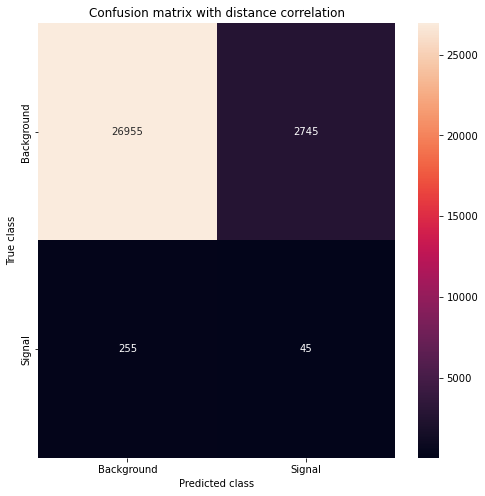

 Accuracy:  0.9
 Recall:  0.15
 Precision:  0.016129032258064516


In [67]:
LABELS = ['Background','Signal']

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

# with DisCo

threshold_fixed = 0.17065

pred_y = [1 if e > threshold_fixed else 0 for e in error_class.Reconstruction_error.values]
error_class['pred'] = pred_y
conf_matrix = confusion_matrix(error_class.True_class, pred_y)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
ax.set_title("Confusion matrix with distance correlation")
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

plt.show()

# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_class['True_class'], error_class['pred']))
print(" Recall: ",recall_score(error_class['True_class'], error_class['pred']))
print(" Precision: ",precision_score(error_class['True_class'], error_class['pred']))


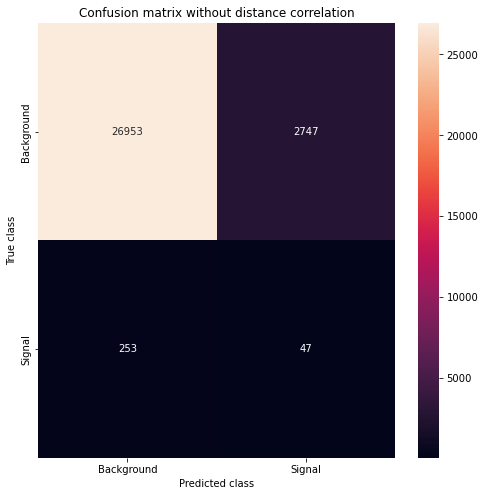

normal Accuracy:  0.9
normal Recall:  0.15666666666666668
normal Precision:  0.016821760916249106


In [68]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

# without DisCo

threshold_fixed = 0.209988

pred_y = [1 if e > threshold_fixed else 0 for e in n_error_class.Reconstruction_error.values]
n_error_class['pred'] = pred_y
conf_matrix = confusion_matrix(n_error_class.True_class, pred_y)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
ax.set_title("Confusion matrix without distance correlation")
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')


plt.show()


# print Accuracy, precision and recall
print("normal Accuracy: ",accuracy_score(n_error_class['True_class'], n_error_class['pred']))
print("normal Recall: ",recall_score(n_error_class['True_class'], n_error_class['pred']))
print("normal Precision: ",precision_score(n_error_class['True_class'], n_error_class['pred']))

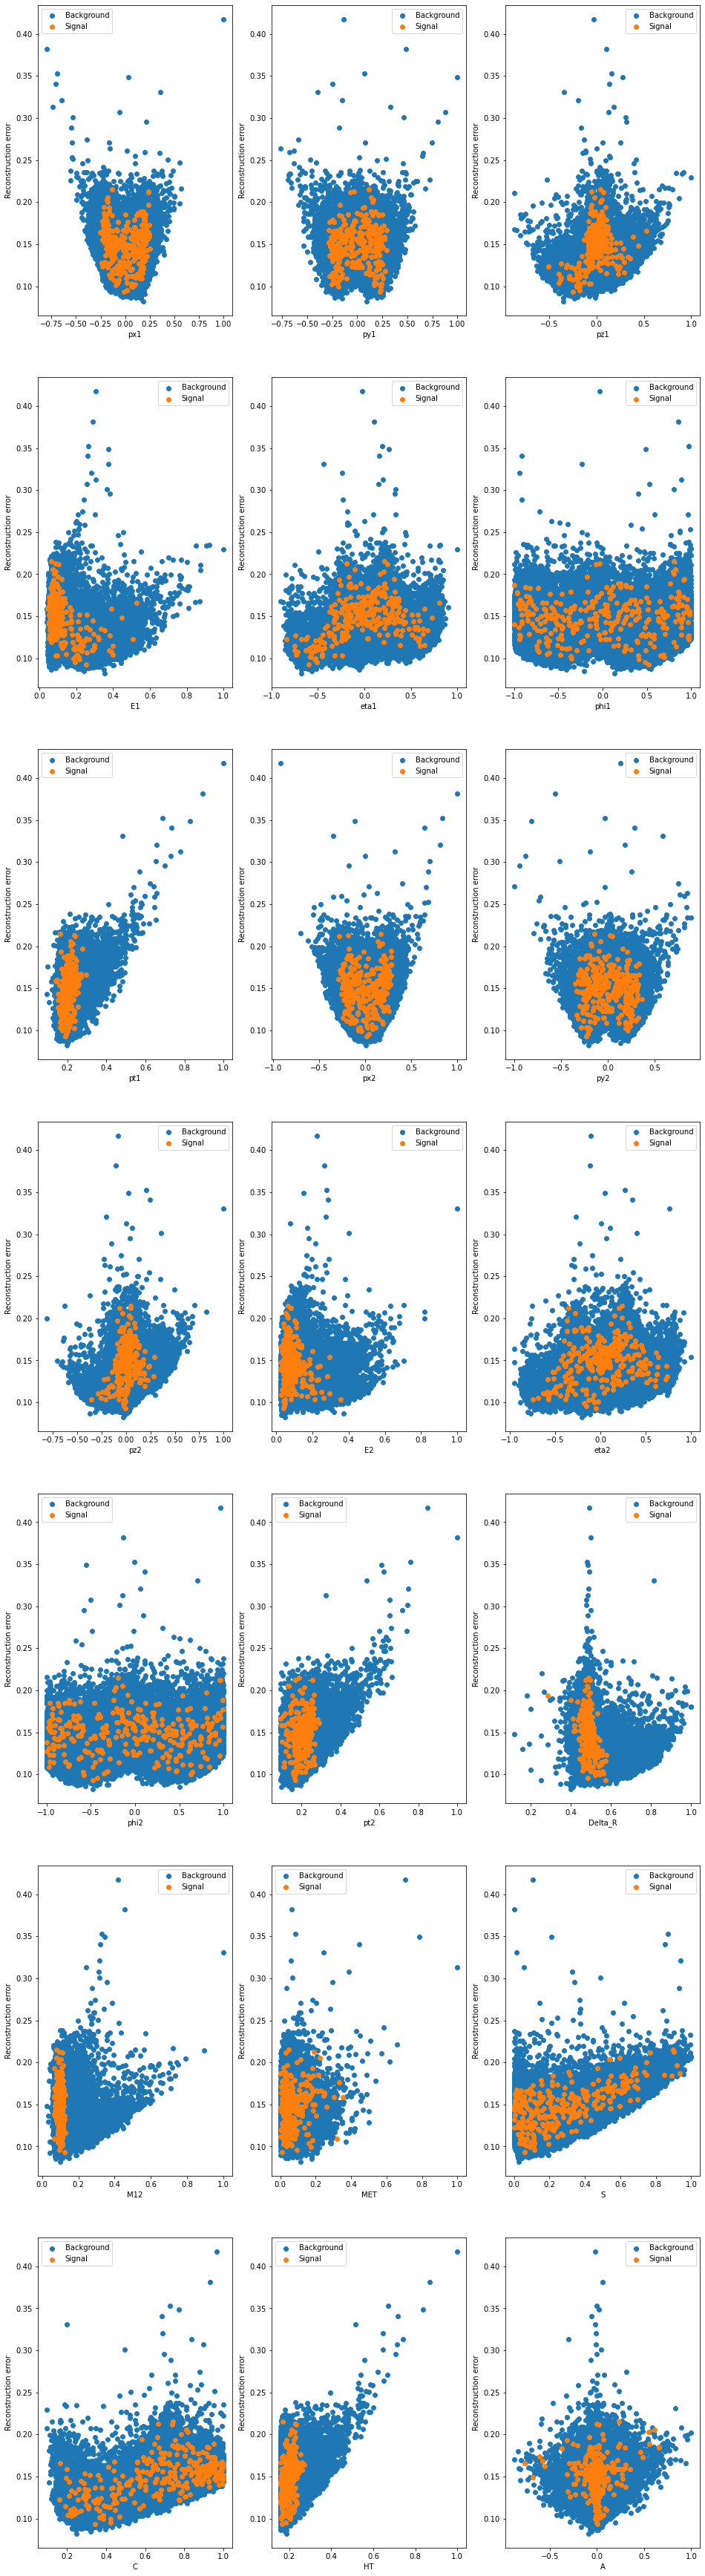

In [69]:
groups = best_model_df.groupby('class')
fig, ax = plt.subplots(7,3)
fig.set_size_inches(16,9*7)

#for i,col in enumerate(results_ditc[sort_model_names[0]]['data'].columns[:-4]):

for i,col in enumerate(best_model_df.columns[1:-3]):
    for name, group in groups:


        ax[i//3,i%3].scatter(group[col], group.reconstruction_error, 
                label= "Signal" if name == 1 else "Background")

        ax[i//3,i%3].legend()

        ax[i//3,i%3].set_ylabel("Reconstruction error")

        ax[i//3,i%3].set_xlabel(col)
        
        ax[i//3,i%3].grid()

plt.show()

# Misc

In [70]:
import time

n_elements = 1250

toolbar_width = 100


for i in range(0,n_elements+1):
    time.sleep(0.1) # do real work here
    # update the bar
    percent = i/n_elements *100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,i,n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()
    if i < (n_elements):
        sys.stdout.write("\r")  


[----------------------------------------------------------------------------------------------------] 100.00% - 1250 of 1250

In [71]:
class progress_bar:
    
    
    def __init__(self, n_elements=100,toolbar_width=50):
        
        import sys
        
        self.progress = 0
        self.n_elements = n_elements
        self.toolbar_width = toolbar_width
        print('Hello,World!')

    def begin():

        # update the bar
        percent = self.progress/n_elements *100

        info = '{:.2f}% - {:d} of {:d}'.format(percent,self.progress,self.n_elements)

        formated_bar = '-'*int(percent) + ' '*int(100-percent)

        sys.stdout.write('[%s] %s' % (formated_bar,info))
        sys.stdout.flush()
    
    def update():
        
        self.progress += 1

        # update the bar
        percent = self.progress/n_elements *100

        info = '{:.2f}% - {:d} of {:d}'.format(percent,self.progress,n_elements)

        formated_bar = '-'*int(percent) + ' '*int(100-percent)

        print('[%s] %s' % (formated_bar,info))
        sys.stdout.flush()
        
        if self.progress < (self.n_elements):
            sys.stdout.write("\r")


In [72]:
n_elements=100
bar = progress_bar(n_elements=n_elements)
bar.begin

for i in range(n_elements):
    time.sleep(0.01)
    bar.update

Hello,World!


In [73]:
from scipy import stats
rng = np.random.default_rng()

In [74]:

n1 = 200  # size of first sample
n2 = 300  # size of second sample

In [75]:
rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1, random_state=rng)
rvs2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5, random_state=rng)
rs = stats.ks_2samp(rvs1, rvs1).pvalue

In [76]:
rs.pvalue

AttributeError: 'numpy.float64' object has no attribute 'pvalue'

In [ ]:
import tensorflow as tf
tf.map_fn(fn=lambda t: tf.range(t[:,], t + 3), elems=tf.constant([[3, 5, 2],[4,5,6]]))


InvalidArgumentError: in user code:

    /tmp/ipykernel_48531/3198347132.py:2 None  *
        lambda t: tf.range(t, t + 3), elems=tf.constant([3, 5, 2]))
    /home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1877 range
        return gen_math_ops._range(start, limit, delta, name=name)
    /home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:7192 _range
        _ops.raise_from_not_ok_status(e, name)
    /home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:6862 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    InvalidArgumentError: start must be a scalar, not shape [3] [Op:Range]


In [ ]:

You can calculate your 'values_array' by converting the "tensor-to-list" or "tensor-to-numpy". by using eval()